#### Required Python libraries 

In [0]:
import numpy  as np
import matplotlib.pyplot as plt
import librosa  # package for speech and audio analysis
from sklearn import mixture
from sklearn.metrics import accuracy_score,confusion_matrix
plt.style.use('default')

## INDEX

1. OBJECTIVE

2. DATABASE

3. READING SPEECH FILES AND FEATURE EXTRACTION

4. SPEAKER IDENTIFICATION SYSTEM

> 4.1. TRAINING STAGE

> 4.2. TEST STAGE (CLEAN CONDITIONS)

> 4.3. EVALUATION (CLEAN CONDITIONS)

> 4.4. TEST STAGE (NOISY CONDITIONS)

> 4.5. EVALUATION (NOISY CONDITIONS)

5. IMPROVEMENTS ON THE BASELINE SYSTEM

---
## 1. OBJECTIVE 
---
The objective is to implement a **text-independent Speaker Identification (SI) system based on Gaussian Mixture Models (GMM)**. This system takes a speech utterance from an unknown speaker and provides the name or identification code of that speaker.



---
## 2. DATABASE 
---
The database contains speech from **16 different speakers** and  it has been recorded at a **sampling frequency of 16 kHz** (subdirectory ***“speechdata”***). It comprises speech files of three different types:

* **Training material.** These files  (listed in the file ***“Train_List.txt”***) will be used for building the specific-speaker models.

* **Test material 1.** These files (listed in the file ***“Test_List1.txt”***) will be used for evaluating the system in clean conditions.

* **Test material 2.** These files (listed in the file ***“Test_List2.txt”***) will be used for evaluating the system in noisy conditions.

The three lists have the following format per line:

```
name_of_speech_file   speaker_identifier
```




In [123]:
# --------------------------------------------------------------------
# Lists of training and testing speech files
# --------------------------------------------------------------------
nomlist_train = 'Train_List.txt';
nomlist_test = ['Test_List1.txt', 'Test_List2.txt']
print("Training list: " + nomlist_train)
print("Test list 1 (clean conditions): "+ nomlist_test[0])
print("Test list 2 (noisy conditions): "+ nomlist_test[1])

Training list: Train_List.txt
Test list 1 (clean conditions): Test_List1.txt
Test list 2 (noisy conditions): Test_List2.txt


---
## 3. READING SPEECH FILES AND FEATURE EXTRACTION 
---
The following code shows an example of reading a speech file with the function **load** from the *librosa* library.

speechdata/irm01/irm01_s01_test1.wav
Number of samples in file speechdata/irm01/irm01_s01_test1.wav = 41386
Sampling frequency = 16000 Hz


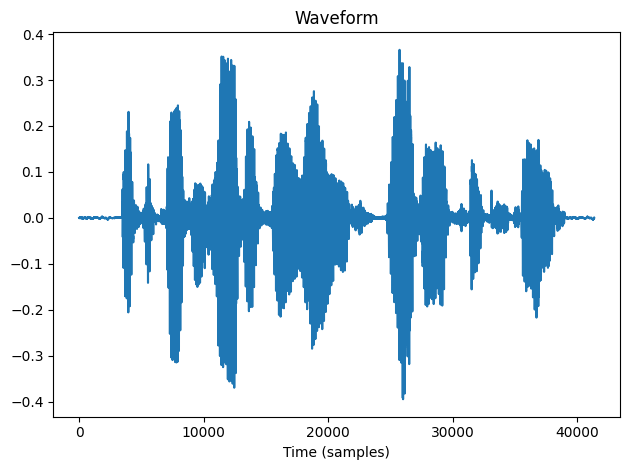

In [124]:
# --------------------------------------------------------------------
# Reading a speech file from the database
# --------------------------------------------------------------------
speech_name = 'speechdata/irm01/irm01_s01_test1.wav'
print(speech_name)

# x: speech signal
# fs: sampling frequency
x, fs = librosa.load(speech_name, sr=None)
print("Number of samples in file "+speech_name+" = "+str(x.shape[0]))
print("Sampling frequency = "+str(fs)+" Hz")

fig, ax = plt.subplots()
plt.plot(x)
plt.title('Waveform')
ax.set_xlabel('Time (samples)')
plt.tight_layout()
plt.show()


In the following, we show an example of feature extraction for the previous speech signal *x*.

In particular, we want to compute a set of mel-frequency cepstrum coefficients (MFCC) with the following configuration:

* Size of the analysis window = 20 ms

* Frame period or hop length = 10 ms

* Number of filters in the mel filterbank = 40

* Number of MFCC components = 20

For doing that, we are going to use the function **mfcc** from the module *feature* of the *librosa* package. This function has, among others, the following input arguments:

* y: speech signal 
* sr: sampling frequency
* n_fft: window size (in samples)
* hop_length: frame period or hop length (in samples)
* n_mels: number of filters in the mel filterbank
* n_mfcc: number of MFCC components

Note that in this function the window size and the hop length must be expressed in samples. Taking into account that the sampling frequency (fs) indicates that 1 second correspond to fs samples (in our case, as fs=16 kHz, 1 second corresponds to 16000 samples), the conversion from **seconds** to **samples** is performed by:

```
samples = seconds*fs = seconds*16000
```

With the previous information, fill the values of the configuration variables in the next code.



In [0]:
# --------------------------------------------------------------------
# Configuration variables for feature extraction
# --------------------------------------------------------------------

fs = 16000        # Sampling frequency
wst = 0.02       # Window size (seconds)
fpt = 0.01      # Frame period (seconds) 
nfft = round(wst*fs)      # Window size (samples)
fp = round(fpt*fs)        # Frame period (samples)
nbands = 40    # Number of filters in the filterbank
ncomp =  20    # Number of MFCC components


The dimensions of the resulting MFCC must be,

```
(ncomp x T)
```

being *T* the number of frames of the speech signal, which is computed as the number of samples of the speech signal divided by the hop length (in samples), rounded off to the ceil integer.

The following code computes the MFCC features considering the previously configured variables.




In [126]:
# --------------------------------------------------------------------
# Example of MFCC computation
# --------------------------------------------------------------------

# Feature extraction (MFCC computation)
mfcc = librosa.feature.mfcc(y=x, sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp).T

mfcc.shape

(259, 20)

---
## 4. SPEAKER IDENTIFICATION SYSTEM 
---
The speaker identification system to be implemented consists of two main stages,

* **Enrollment or training phase.** 

* **Identification or test phase.**

# 4.1. TRAINING STAGE
In this stage, the models of the different speakers in the system are built.

*	Loading of the training material (speech files listed in ***“Train_List.txt”***).

* For each speaker (recall that there are 16 differente speakers in the database),

> *	**Feature extraction**. As baseline features, we recommend the use of the conventional **MFCC parameters**, setting **the window size, the frame period and the number of cepstral components to 20 ms, 10 ms and 20, respectively** (see Section 3).

> * **Speaker GMM models building.** The **GaussianMixture** function from the *mixture* module of the *scklearn* package, which implements the EM algorithm, can be used for this purpose. Use **8 gaussians** per model and **diagonal covariances**. 

At the end of this process, a set of GMM models (one model per speaker) is generated. Note that in this stage, only the training material can be used (listed in ***“Train_List.txt”***).




In [0]:
# --------------------------------------------------------------------
# Training stage
# --------------------------------------------------------------------

# Configuration variables for the training stage
nspk = 16     # Number of speakers 
ngauss = 8   # Number of gaussians in the GMM models

# Loading of the training files for all speakers
# The format of the list (per line) is,
# name_of_speech_file   speaker_identifier
fid = open(nomlist_train,"r")
data = np.genfromtxt(fid,dtype='str')
fid.close()

# Number of training files
nfiles_train = data.shape[0]

# 'files_speech_train': name of each speech file in the training set
# 'labels_train': label (speaker identifier) corresponding to each speech file
files_speech_train = []
labels_train = []
for i in range(nfiles_train):
    files_speech_train.append(data[i][0])
    labels_train.append(data[i][1])

labels_train = np.array(labels_train,dtype=np.int16)

# Speaker GMM models building
models = []

for i in range(nspk):

    # Loading of the training file for speaker "i"
    x, sr = librosa.load(files_speech_train[i], sr=None)

    # Feature extraction
    mfcc = librosa.feature.mfcc(y=x, sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp).T


    # Speaker GMM model building for speaker "i"
    gmm = mixture.GaussianMixture(n_components = ngauss, covariance_type ='diag',random_state=1)
    models.append(gmm.fit(mfcc))




# 4.2. TEST STAGE (CLEAN CONDITIONS)
In this stage, the identified or predicted speaker is obtained for the case of clean conditions. For doing that, the following steps must be done,

*	Loading of the test material in **clean conditions** (speech files listed in ***“Test_List1.txt”***).

* For each test file of the unknown speaker,

> *	**Feature extraction**. We extract MFCC parameters with the same configuration as in the training stage.

> * **Log-likelihood computation of each model for the current test file.** 
We have to compute the log-likelihood of the test MFCCs given each one of the 16 speaker models obtained in the training stage. The **score_samples** function can be used for this purpose.

> * **Selection of the identified speaker**. We select the identified or predicted speaker according to the model which achieves the maximum log-likelihood. 




In [0]:
# --------------------------------------------------------------------
# Test stage (clean conditions)
# --------------------------------------------------------------------

# Reading of the list containing the speech test files
# The format of the list (per line) is,
# name_of_speech_file   speaker_identifier
fid = open(nomlist_test[0],"r")
data = np.genfromtxt(fid,dtype='str')
fid.close()

# Number of test files  
nfiles_test = data.shape[0]

# 'files_speech_test': name of each speech file in the test set
# 'labels_test': label (speaker identifier) corresponding to each speech file
files_speech_test = []
labels_test = []

for i in range(nfiles_test):
    files_speech_test.append(data[i][0])
    labels_test.append(data[i][1])

labels_test = np.array(labels_test,dtype=np.int16)

# 'pred_spk': predicted speakers
pred_spk = np.zeros(nfiles_test,dtype=np.int16)
log_likelihood_values = []

# Loop for each test file
for k in range(nfiles_test):

    # Loading of the test files
    x, sr = librosa.load(files_speech_test[k], sr=None)
  
  
    # Feature extraction
    mfcc = librosa.feature.mfcc(y=x, sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp).T

    # Log-likelihood computation of each model for the current test file
    #The score_samples computes the weighted log probabilities for each sample
    scores = []
    for model in models:
        data = (model.score_samples(mfcc))
        scores.append(sum(data))


  # Selection of the identified speaker
  # Select the identified speaker based on the model that produce the max log-likelihood
    pred_spk[k] = scores.index(max(scores))
  

In [129]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 4.3. EVALUATION (CLEAN CONDITIONS)
This task consists of the evaluation of the system in clean conditions.

The performance of the speaker identification system is measured in terms of the **identification accuracy** (percentage of correctly identified test files with respect to the total number of test files).



In [130]:
# --------------------------------------------------------------------
# Evaluation (clean conditions)
# --------------------------------------------------------------------
correct = 0
# Computation of the identification accuracy
##################################
# - WRITE YOUT CODE HERE
for k in range(nfiles_test):
    if pred_spk[k] == labels_test[k]:
    correct = correct + 1

accuracy = correct / nfiles_test
print(accuracy)
##################################


0.9875


# 4.4. TEST STAGE (NOISY CONDITIONS)
In this stage, the identified or predicted speaker is obtained for the case of noisy conditions.

Repeat the Section 4.2 but now using the test material in **noisy conditions** (speech files listed in ***“Test_List2.txt”***).


In [0]:
# --------------------------------------------------------------------
# Test stage (noisy conditions)
# --------------------------------------------------------------------

##################################
# - WRITE YOUT CODE HERE
# Reading of the list containing the speech test files
# The format of the list (per line) is,
# name_of_speech_file   speaker_identifier
fid = open(nomlist_test[1],"r")
data = np.genfromtxt(fid,dtype='str')
fid.close()

# Number of test files  
nfiles_test = data.shape[0]

# 'files_speech_test': name of each speech file in the test set
# 'labels_test': label (speaker identifier) corresponding to each speech file
files_speech_test = []
labels_test = []

for i in range(nfiles_test):
    files_speech_test.append(data[i][0])
    labels_test.append(data[i][1])

labels_test = np.array(labels_test,dtype=np.int16)

# 'pred_spk': predicted speakers
pred_spk = np.zeros(nfiles_test,dtype=np.int16)
log_likelihood_values = []

# Loop for each test file
for k in range(nfiles_test):

    # Loading of the test files
    ##################################
    # - WRITE YOUT CODE HERE
    x, sr = librosa.load(files_speech_test[k], sr=None)
    ##################################

    # Feature extraction
    ##################################
    # - WRITE YOUT CODE HERE
    mfcc = librosa.feature.mfcc(y=x, sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp).T
    ##################################

    # Log-likelihood computation of each model for the current test file
    ##################################
    # - WRITE YOUT CODE HERE
    #The score_samples computes the weighted log probabilities for each sample

    scores = []
    for model in models:
        data = (model.score_samples(mfcc))
        scores.append(sum(data))

    # Selection of the identified speaker
    pred_spk[k] = scores.index(max(scores))
  ##################################


# 4.5. EVALUATION (NOISY CONDITIONS)
Evaluate the performance of the system in noisy conditions by computing the **identification accuracy** as in Section 4.3.


In [132]:
# --------------------------------------------------------------------
# Evaluation (noisy conditions)
# --------------------------------------------------------------------

# Computation of the identification accuracy
correct = 0
for k in range(nfiles_test):
    if pred_spk[k] == labels_test[k]:
    correct = correct + 1

accuracy = correct / nfiles_test
print(accuracy)


0.48125


---
## 5. IMPROVEMENTS ON THE BASELINE SYSTEM [OPTIONAL] 
---
In this task, students can propose any improvement of the baseline system by, for example, including new acoustic features (LPC, …) or trying different number of Gaussians in the GMM models or computing confusion matrices for the evalution of the system.


In [0]:
# --------------------------------------------------------------------
# Improvements on the baseline system
# --------------------------------------------------------------------

# --------------------------------------------------------------------
# Training stage
# --------------------------------------------------------------------

# Configuration variables for the training stage
nspk = 16    # Number of speakers 
ngauss = 20  # Number of gaussians in the GMM models

# Loading of the training files for all speakers
# The format of the list (per line) is,
# name_of_speech_file   speaker_identifier
fid = open(nomlist_train,"r")
data = np.genfromtxt(fid,dtype='str')
fid.close()

# Number of training files
nfiles_train = data.shape[0]

# 'files_speech_train': name of each speech file in the training set
# 'labels_train': label (speaker identifier) corresponding to each speech file
files_speech_train = []
labels_train = []
for i in range(nfiles_train):
    files_speech_train.append(data[i][0])
    labels_train.append(data[i][1])

labels_train = np.array(labels_train,dtype=np.int16)

# Speaker GMM models building
models = []

for i in range(nspk):

    # Loading of the training file for speaker "i"
    x, sr = librosa.load(files_speech_train[i], sr=None)
    ##################################

    # Feature extraction
    mfcc = librosa.feature.mfcc(y=x, sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp).T

    #Compute delta features: local estimate of the derivative of the input data along the selected axis 
    mfcc_delta = librosa.feature.delta(mfcc)

    #Compute the second derivates
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    mfcc = np.concatenate((mfcc, mfcc_delta , mfcc_delta2),axis = 1 )

    #Compute chroma features
    chroma_features =  librosa.feature.chroma_stft(y=x, sr=fs, n_fft=nfft, hop_length=fp).T
    mfcc = np.concatenate((mfcc, chroma_features), axis=1)

    #Compute the zero crossing rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=x, frame_length=nfft, hop_length=fp).T
    mfcc = np.concatenate((mfcc, zero_crossing_rate), axis=1)

    #Compute the fundamental_frequency_feature 
    pitches, magnitudes = librosa.piptrack(y=x, sr=fs, n_fft=nfft, hop_length=fp)
    pitch = []
    for t in range(magnitudes.shape[1]):
    index = magnitudes[:, t].argmax()
    pitch.append(pitches[index, t])

    pitch = np.c_[pitch]
    mfcc = np.concatenate((mfcc, pitch), axis=1)

    #Compute the Spectral-roll off
    rolloff = librosa.feature.spectral_rolloff(y=x, sr=fs, n_fft=nfft, hop_length=fp).T
    mfcc = np.concatenate((mfcc, rolloff), axis=1)

    # Speaker GMM model building for speaker "i"
    gmm = mixture.GaussianMixture(n_components = ngauss, covariance_type ='diag', max_iter=500,random_state=1)
    models.append(gmm.fit(mfcc))
    



In [0]:


##################################
# --------------------------------------------------------------------
# Test stage (noisy conditions)
# --------------------------------------------------------------------

# Reading of the list containing the speech test files
# The format of the list (per line) is,
# name_of_speech_file   speaker_identifier
fid = open(nomlist_test[1],"r")
data = np.genfromtxt(fid,dtype='str')
fid.close()

# Number of test files  
nfiles_test = data.shape[0]

# 'files_speech_test': name of each speech file in the test set
# 'labels_test': label (speaker identifier) corresponding to each speech file
files_speech_test = []
labels_test = []

for i in range(nfiles_test):
    files_speech_test.append(data[i][0])
    labels_test.append(data[i][1])

labels_test = np.array(labels_test,dtype=np.int16)

# 'pred_spk': predicted speakers
pred_spk = np.zeros(nfiles_test,dtype=np.int16)

# Loop for each test file
for k in range(nfiles_test):

    # Loading of the test files
    x, sr = librosa.load(files_speech_test[k], sr=None)

    # Feature extraction
    mfcc = librosa.feature.mfcc(y=x, sr=fs, n_fft=nfft, hop_length=fp, n_mels=nbands, n_mfcc=ncomp).T

    #Compute delta features: local estimate of the derivative of the input data along the selected axis 
    mfcc_delta = librosa.feature.delta(mfcc)

    #Compute the second derivates
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    mfcc = np.concatenate((mfcc, mfcc_delta , mfcc_delta2),axis = 1 )

    #Compute chroma features
    chroma_features =  librosa.feature.chroma_stft(y=x, sr=fs, n_fft=nfft, hop_length=fp).T
    mfcc = np.concatenate((mfcc, chroma_features), axis=1)

    #Compute the zero crossing rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=x, frame_length=nfft, hop_length=fp).T
    mfcc = np.concatenate((mfcc, zero_crossing_rate), axis=1)

    #Compute the fundamental_frequency_feature 
    pitches, magnitudes = librosa.piptrack(y=x, sr=fs, n_fft=nfft, hop_length=fp)
    pitch = []
    for t in range(magnitudes.shape[1]):
        index = magnitudes[:, t].argmax()
        pitch.append(pitches[index, t])

    pitch = np.c_[pitch]
    mfcc = np.concatenate((mfcc, pitch), axis=1)

    #Compute the Spectral-roll off
    rolloff = librosa.feature.spectral_rolloff(y=x, sr=fs, n_fft=nfft, hop_length=fp).T
    mfcc = np.concatenate((mfcc, rolloff), axis=1)

    # Log-likelihood computation of each model for the current test file
    #The score_samples computes the weighted log probabilities for each sample
    scores = []
    for model in models:
        data = (model.score_samples(mfcc))
        scores.append(sum(data))

    # Selection of the identified speaker
    # Select the identified speaker based on the model that produce the max log-likelihood
    pred_spk[k] = scores.index(max(scores))




In [135]:
# --------------------------------------------------------------------
# Evaluation (noisy conditions with improvements)
# --------------------------------------------------------------------

# Computation of the identification accuracy
correct = 0
for k in range(nfiles_test):
    if pred_spk[k] == labels_test[k]:
        correct = correct + 1

accuracy = correct / nfiles_test
print(accuracy)


0.80625
